# Projet 5 - <font color='green'>Notebook 4</font> - Segmentez des clients d'un site e-commerce

L'objectif de ce projet est de réaliser une segmentation de clients à partir des [données du site de commerce électronique Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).

Les données de base sont constituées de 9 fichiers et concernent les commandes effectuées au cours d'une période de 2 ans. Les fichiers ne fournissent pas d'information sur les clients autres que celles nécessaires aux commandes par e-commerce (localisation, commandes effectuées, dates, articles commandés, prix, paiements et éventuels commentaires clients). Pour cette raison, la segmentation est centrée sur l'approche RFM (Récence, Fréquence et Montant des commandes), enrichie le cas échéant par des caractéristiques complémentaires.

Le projet consiste à :

- (a) constituer un jeu de données clients nettoyé,
- (b) l'analyser pour en acquérir la meilleure compréhension,
- (c) identifier les caractéristiques utiles à la segmentation,
- (d) préparer les données pour le machine learning : transformation et réduction de la dimensionnalité afin de permettre la visualisation,
- (e) effectuer des apprentissages non supervisés avec différents algorithmes pour déterminer le clustering le plus pertinent,
- (f) effectuer l'analyse métier du clustering pour en valider l'usage par le marketing de l'entreprise
- (g) estimer la pérennité du modèle de clustering dans le temps afin de donner de la visibilité sur son temps d'utilisation comparé au délai de réalisation des actions marketing.

Le Notebook 4 couvre l'étape (g) ci-dessus.

## Livrables
Ce projet est mené en langage Python, utilisant les librairies Numpy, Pandas, Matplotlib et Seaborn.
Le machine learning utilise principalement les librairies scikit-learn et scipy.
Les versions sont vérifiées en début de script de ce Notebook.
L'IDE utilisé est Pycharm.

Le rapport est constitué des fichiers suivants :
- Notebook 1 - Analyse exploratoire <font color='green'>P5_notebook1_analyse_exploratoire.ipynb</font>
- Notebook 2 - Feature engineering <font color='green'>P5_notebook2_feature_engineering.ipynb</font>
- Notebook 3 - Modèle de clustering <font color='green'>P5_notebook3_modele_clustering.ipynb</font>
- Notebook 4 - Maintenance des clusters <font color='green'>P5_notebook4_maintenance_clusters.ipynb</font>
- Fichier des fonctions Python utilisées par les notebooks <font color='green'>P5_fonctions.py</font>
- Les fichiers de données se trouvent dans le répertoire <font color='green'>.\P5_data</font>

<a id="sommaire"></a>
## Sommaire
1. [Initialisations](#init)
&nbsp;
2. [Établissement du modèle de base](#model_0)
    1. [Chargement du dataset](#dataset)
    2. [Fonctions d'établissement du jeu de donnée clients à une date spécifique](#dataset_date_split)
    3. [Établissement du plan de projection pour la visualisation](#projection)
    4. [Définition du jeu de données et du modèle de base](#dataset_n_model_0)
3. [Évolution du modèle dans le temps](#analyse)
    1. [Evolution de l'index de Rand ajusté (ARI)](#ari)
    2. [Représentation de la prédiction au terme du jeu de données](#final_predict)
4. [Conclusion](#conclusion)

<a id="init"></a>
## 1 - Initialisations

In [1]:
# Import des librairies et fonctions
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

import nltk
import copy
import sys

# Fonctions support du projet
import P5_fonctions as fct

# Mesure du temps de calcul:
import timeit
#start_time = timeit.default_timer()
# ... code dont on veut mesurer la durée ...
#elapsed = timeit.default_timer() - start_time
#print(f"Temps de calcul {fct.elapsed_format(elapsed)}")

# Pour afficher les graphiques dans le Notebook
%matplotlib inline
# Pour afficher les graphiques dans une fenêtre matplotlib
#%matplotlib qt

# Gestion des conflits d'installation de ipython et jupyter avec windows:
# - installer pipwin (pip install pipwin), puis
# - installer ipython et jupyter avec pipwin

# Display options
from IPython.display import display, display_html, display_png, display_svg, Image
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 199)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

# Colorama
from colorama import Fore, Back, Style
# Fore: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Back: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Style: DIM, NORMAL, BRIGHT, RESET_ALL

# Affiche les versions de Python et packages
print(Fore.BLACK + Style.BRIGHT + Back.WHITE
      + 'Versions de Python et des principales librairies utilisées :\n' +
      Style.RESET_ALL)
print('- Python : ' + sys.version)
print('- Numpy : ' + np.__version__)
print('- Pandas : ' + pd.__version__)
print('- Matplotlib : ' + mpl.__version__)
print('- Seaborn : ' + sns.__version__)

!jupyter --version

# Suppression des warnings de dépréciation lié à l'utilisation de fig.colorbar
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

Versions de Python et des principales librairies utilisées :

- Python : 3.10.4 | packaged by conda-forge | (main, Mar 30 2022, 08:38:02) [MSC v.1916 64 bit (AMD64)]
- Numpy : 1.22.3
- Pandas : 1.4.2
- Matplotlib : 3.5.1
- Seaborn : 0.11.2
Selected Jupyter core packages...
IPython          : 8.3.0
ipykernel        : 6.9.1
ipywidgets       : 7.6.5
jupyter_client   : 7.2.2
jupyter_core     : 4.10.0
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.5.13
nbconvert        : 6.4.4
nbformat         : 5.3.0
notebook         : 6.4.11
qtconsole        : 5.3.0
traitlets        : 5.1.1


[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="model_0"></a>
## 2 - Mise en place du modèle de base et des fonctions supports
Dans ce chapitre, nous allons charger le jeu de donné initial (cf notebook1, §2.4), définir les fonctions nécessaires à l'établissement du dataset clients tel que disponibles à une date spécifique, préparer un plan de projection unique pour la visualisation des données et établir le modèle de base de clustering.

<a id="dataset"></a>
### 2.1 - Chargement du dataset
Nous chargeons le dataset enregistré dans le notebook1 qui contient l'ensemble des informations nécessaires afin de constituer un dataset clients avec les variables RFM avec les valeurs disponible jusqu'à une date spécifique.

In [2]:
# Répertoire et fichiers de données
data_dir = '.\P5_data'
file = 'data_nb4.csv'

# Chargement du jeu de données
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Chargement du jeu de données\n" + Style.RESET_ALL)
data = pd.read_csv(data_dir + "\\" + file , sep=';', encoding='utf-8-sig', low_memory=False)
# Mise au format date de la variable 'order_purchase_timestamp'
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'], errors='coerce')
print(Fore.GREEN + "► Informations :" + Style.RESET_ALL)
display(data.info())
print(Fore.GREEN + "► Entête et fin de jeu de données :" + Style.RESET_ALL)
display(pd.concat([data.head(2), data.tail(2)], axis=0))

Chargement du jeu de données

► Informations :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100225 entries, 0 to 100224
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   customer_unique_id        100225 non-null  object        
 1   order_id                  100225 non-null  object        
 2   order_purchase_timestamp  100225 non-null  datetime64[ns]
 3   payment_value             100225 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.1+ MB


None

► Entête et fin de jeu de données :


,customer_unique_id,order_id,order_purchase_timestamp,payment_value
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,146.87
1,9eae34bbd3a474ec5d07949ca7de67c0,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,275.79
100223,8c3c961a52bb5a0ffbce1d4e6d25cd67,2c12150c742ae2fa48bc703964c16c5f,2018-07-28 17:55:27,77.50
100224,428f4721a509be8c52de6ec2900ba918,9f7ba492c273ffac8f90a623b8eadd3b,2018-08-23 12:31:37,24.69


[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="dataset_date_split"></a>
### 2.2 - Fonctions d'établissement du jeu de donnée clients à une date spécifique
Nous établissons ici les fonctions utiles à l'établissement du dataset clients contenant les informations jusqu'à la date spécifiée.
- Fonction 'date_ref' : renvoie la date correspondant à 'n_days' jours avant la date de fin du dataset complet.
&nbsp;
- Fonction 'customer_dataset' : renvoie le dataset client à la date donnée ; ce dataset comprend l'écrêtage de 'frequency' et 'monetary' tel que vu au notebook2 ; la variable 'frequency' correspond, avant son écrêtage, au nombre de commandes effectuées par le client, afin de rendre cette variable insensible à la fenêtre de temps du dataset.

In [3]:
# Détermination d'une date 'date_ref' 'n_days' jours avant la date de fin du dataset complet
import datetime
def date_ref(n_days=180):
    return data['order_purchase_timestamp'].max() - datetime.timedelta(days=n_days)

In [4]:
# Fonction de constitution du fichier clients à une date définie
def customer_dataset(date):

    # Filtrage du jeu d'entrée pour obtenir les données jusqu'à la date définie
    data_ref = data.loc[data['order_purchase_timestamp']<=date]

    # Initialisation du jeu de données client
    df_customers = data_ref.groupby(by='customer_unique_id', as_index=False)['order_id'].nunique()
    df_customers.set_index(keys='customer_unique_id', inplace=True)
    df_customers['frequency'] = df_customers['order_id'].apply([lambda x: x if x<2 else 2])

    # Variable 'recency'
    df = data_ref.groupby(by='customer_unique_id')['order_purchase_timestamp'].max()
    df_customers['recency'] = data_ref['order_purchase_timestamp'].max() - df
    df_customers['recency'] = df_customers['recency'].apply(lambda x: x.days + x.seconds/(24*3600))

    # Variable 'monetary' (montant cumulé total écrêté à 700)
    df = data_ref.groupby(by='customer_unique_id')['payment_value'].sum()
    df_customers['monetary'] = df.apply([lambda x: x if x<=700 else 700])

    return df_customers[['recency', 'frequency', 'monetary']]

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="projection"></a>
### 2.3 - Établissement du plan de projection pour la visualisation
Nous établissons ici l'ACP qui sera utilisée pour la visualisation de la population des clients.

Établissement du plan de projection pour la visualisation



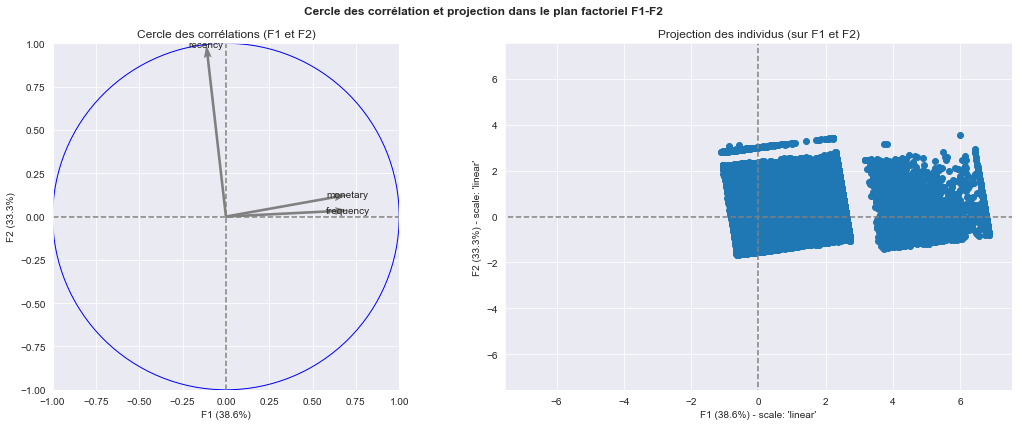

In [5]:
# Établissement du plan de projection pour la visualisation
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

print(Fore.BLACK + Style.BRIGHT + Back.WHITE
      + "Établissement du plan de projection pour la visualisation\n"
      + Style.RESET_ALL)

scaler = StandardScaler()
X = scaler.fit_transform(customer_dataset(date_ref(0)).values)
pca = PCA(n_components=2)
pca.fit(X)
pcs = pca.components_
pca_labels = ['recency', 'frequency', 'monetary']

# Affichage du dataset complet
X_projected = pca.transform(X)
scale = 'linear', 'linear'
c_lims = -1, 1, -1, 1

fct.projetNcircle_plot(pcs, X_projected, 2, pca, [1, 2], scale=scale,
                       c_labels=pca_labels, c_lims=c_lims)

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="dataset_n_model_0"></a>
### 2.4 - Définition du jeu de données et du modèle de base
Le modèle de base est déterminé à une date permettant de disposer d'un jeu suffisamment conséquent pour établir un modèle et d'observer son évolution dans le temps.
Le dataset de base est fixé 180 jours avant la date la plus récente des données disponibles, ce qui permet de disposer de 60% des données pour établir le modèle de base, et de 180 jours pour observer la qualité des prédictions dans le temps.

Modèle de base K-Means sur RFM

► Recherche du nombre optimum de clusters :


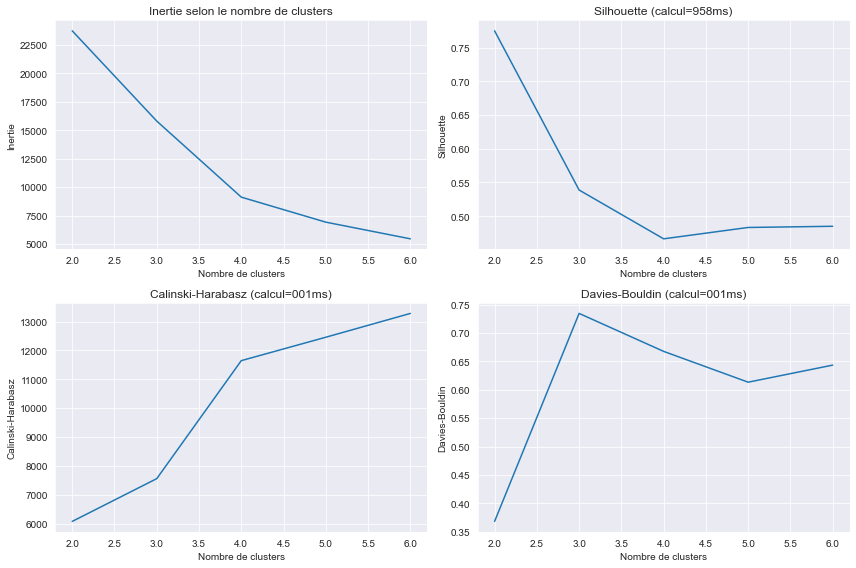

In [6]:
from sklearn.cluster import KMeans

print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Modèle de base K-Means sur RFM\n" + Style.RESET_ALL)

# Détermination du nombre optimum de clusters
print(Fore.GREEN + "► Recherche du nombre optimum de clusters :" + Style.RESET_ALL)
scaler_0 = StandardScaler()
laptime_0 = 450
X_0 = scaler_0.fit_transform(customer_dataset(date_ref(laptime_0)).values)
fct.kmeans_metric_plot(X_0, ks=np.arange(2, 7), eval=['silhouette', 'calinski_harabasz', 'davies_bouldin'])

► Modèle de base sur 12.8% du dataset total, établi sur les 280 premiers jours :


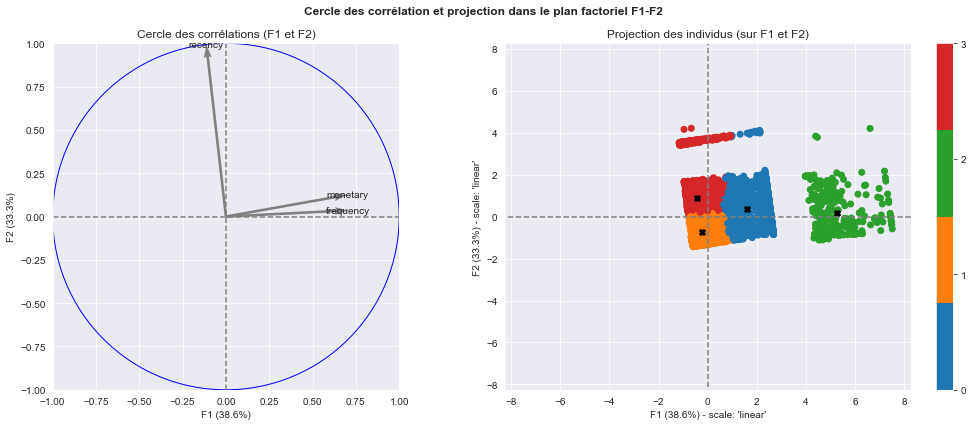

In [7]:
# Modèle de base
print(Fore.GREEN
      + f"► Modèle de base sur {100*len(X_0)/93396:.1f}% du dataset total, établi sur les {365*2-laptime_0} premiers jours :"
      + Style.RESET_ALL)
k = 4
model_0 = KMeans(n_clusters=k)
model_0.fit(X_0)

X_0_projected = pca.transform(X_0)
color = model_0.predict(X_0)
color = (color - color.min()) / (color.max() - color.min())
cmap = fct.discrete_colormap(fct.discrete_palette[:k])[0]
cnames = np.array(range(k))
centroids = pca.transform(model_0.cluster_centers_)
fct.projetNcircle_plot(pcs, X_0_projected, 2, pca, [1, 2], scale=scale,
                       color=color, cnames=cnames, cmap=cmap, centroids=centroids,
                       c_labels=pca_labels, c_lims=c_lims)

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="evolution"></a>
## 3 - Évolution du modèle dans le temps
L'évolution de la qualité de la modélisation du clustering dans le temps est mesurée avec l'index de Rand ajusté qui donne un score proche de 1 lorsque les étiquettes prédites sont en accord avec les étiquettes réelles, et 0 lorsque les étiquettes sont largement indépendantes.

Le modèle initial est établi sur les 280 premiers jours avec seulement 12.8% du dataset total.

Au cours des 450 jours qui suivent l'établissement du modèle initial, l'ARI reste supérieur à 0.8, montrant une bonne similarité entre le cluster prédit et celui établi par le modèle entrainé avec les données effectives. En revanche, au bout de 400 jours, la courbe d'ARI montre de fortes variations à la hausse et à la baisse avec une amplitude entre 0.1 et 0.2, ce qui fait douter de la fiabilité de la prédiction avec l'évolution du dataset.

Par ailleurs, le tracé des clusters prédits et réels au terme du jeu de données (450 jours après la définition du modèle) montre la similarité sur la forme des clusters et le positionnement des centroïdes. L'examen des valeurs réelles des centroïdes montre que la différence porte sur la variable 'recency' (qui augmente avec le temps), ce qui semble logique compte tenu que 97% des clients n'ont effectué qu'une seule commande.

<a id="ari"></a>
### 3.1 - Evolution de l'index de Rand ajusté (ARI)

►  Evolution de la qualité du modèle dans le temps :


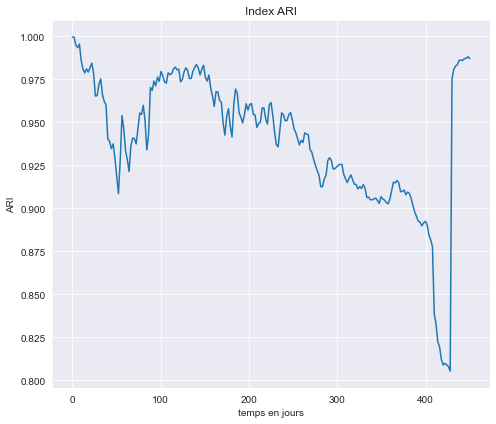

In [8]:
from sklearn import metrics
times = np.linspace(0, laptime_0, int(laptime_0/2))
ARI = []
for time in times:
    scaler_t = StandardScaler()
    X_t = scaler_t.fit_transform(customer_dataset(date_ref((laptime_0 - time))).values)
    labels_pred = model_0.predict(X_t)
    model_t = KMeans(n_clusters=k)
    model_t.fit(X_t)
    labels_true = model_t.predict(X_t)
    ARI.append(metrics.adjusted_rand_score(labels_true, labels_pred))

print(Fore.GREEN + "►  Evolution de la qualité du modèle dans le temps :" + Style.RESET_ALL)
plt.figure(figsize=(7, 6))
plt.plot(times, ARI)
plt.xlabel('temps en jours')
plt.ylabel('ARI')
plt.title("Index ARI")
plt.tight_layout()
plt.show()

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="final_predict"></a>
### 3.2 Représentation de la prédiction au terme du jeu de données

►  Clusters prédits au terme du jeu de données :


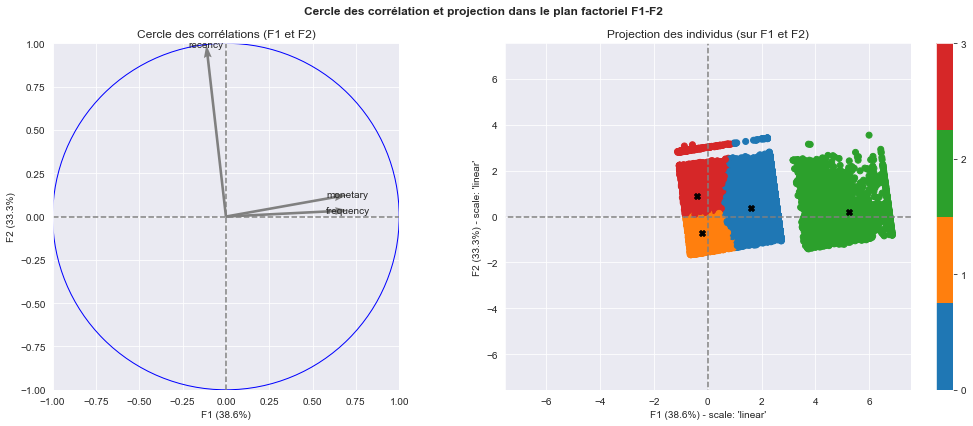

►  Clusters réels au terme du jeu de données :


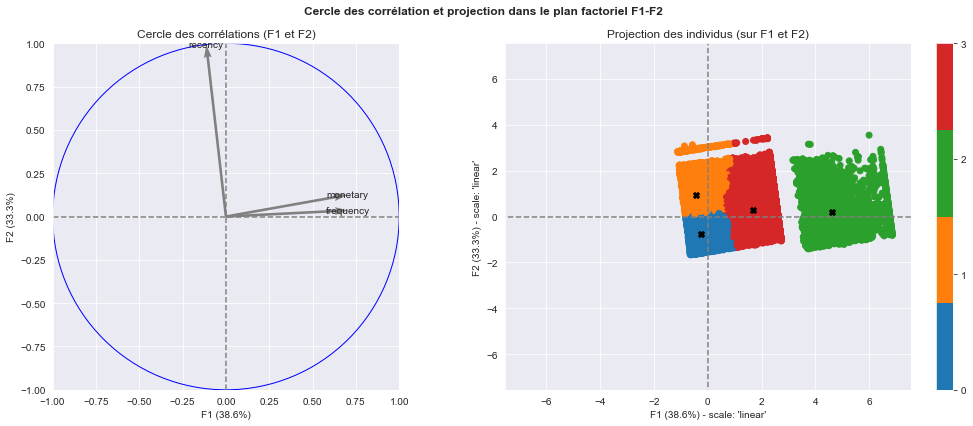

►  Ecarts entre les centroïdes prédits et réels:


,recency,frequency,monetary
0,-99.48,0.00,-2.28
1,-280.24,0.00,-3.30
2,-166.42,-0.00,-22.50
3,-168.39,0.00,-16.72


In [10]:
cmap = fct.discrete_colormap(fct.discrete_palette[:k])[0]
cnames = np.array(range(k))
X_t_projected = pca.transform(X_t)

# Prédiction au terme du jeu de données
print(Fore.GREEN + "►  Clusters prédits au terme du jeu de données :" + Style.RESET_ALL)
color = labels_pred
color = (color - color.min()) / (color.max() - color.min())
centroids = pca.transform(model_0.cluster_centers_)
fct.projetNcircle_plot(pcs, X_t_projected, 2, pca, [1, 2], scale=scale,
                       color=color, cnames=cnames, cmap=cmap, centroids=centroids,
                       c_labels=pca_labels, c_lims=c_lims)

# Réalité au terme du jeu de données
print(Fore.GREEN + "►  Clusters réels au terme du jeu de données :" + Style.RESET_ALL)
color = labels_true
color = (color - color.min()) / (color.max() - color.min())
centroids = pca.transform(model_t.cluster_centers_)
fct.projetNcircle_plot(pcs, X_t_projected, 2, pca, [1, 2], scale=scale,
                       color=color, cnames=cnames, cmap=cmap, centroids=centroids,
                       c_labels=pca_labels, c_lims=c_lims)

# Evolution de la position des centroïdes
print(Fore.GREEN
      + "►  Ecarts entre les centroïdes prédits et réels:"
      + Style.RESET_ALL)
delta_centroids = scaler_0.inverse_transform(model_0.cluster_centers_[[1, 3, 2, 0]]) - scaler_t.inverse_transform(model_t.cluster_centers_)
df = pd.DataFrame(delta_centroids, columns=['recency', 'frequency', 'monetary'])
pd.options.display.float_format = '{:,.2f}'.format
display(df)

<a id="conclusion"></a>
## 4 - Conclusion
La segmentation proposée par le clustering k-Means, même établie avec une fraction du jeu de donnée, est durable sur au moins une année, à la réserve près de la récence qui évolue de manière significative, sans pour autant que cela soit un facteur de grande importance compte tenu du très faible taux de commandes multiples.

[<font color='red'><em>retour sommaire</em></font>](#sommaire)